In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pickle
import os

In [ ]:
data = pd.read_csv("combined_data_nonconcat.csv",header=None)
data = data.sample(frac=1)
data = data.reset_index(drop=True)
labels = data[0]
data = data.drop(0,axis='columns')
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.30)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = np.asarray(y_train.values.tolist())
y_train = y_train.reshape(-1,1)
y_test = np.asarray(y_test.values.tolist())
y_test = y_test.reshape(-1,1)

In [ ]:
print(data.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(17580, 34)
(12306, 34)
(5274, 34)
(12306, 1)
(5274, 1)


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
def displayStats(model,modelname: str,test: np.ndarray,truth: np.ndarray):
    predictions = model.predict(test) #all of them should have this
    print(modelname+" STATS:")
    print("ACCURACY: "+str(accuracy_score(truth,predictions)))

   #not all models have predict_proba
    if callable(getattr(model, "predict_proba", None)):
        soft_predictions = model.predict_proba(test)[:,1]
        print("ROC AUC: "+str(roc_auc_score(truth,soft_predictions)))
    
    cmat = confusion_matrix(truth,predictions)
    disp = ConfusionMatrixDisplay(cmat)
    disp.plot()
    plt.show()

# Catboost Classifier - Attempt 2
---
## Issues with the first attempt
---
We found that our first attempt varied (in accuracy) greatly between different random test sets. This could indicate overfitting portions of the data. This could be due to a relatively small dataset size, which leads to the classifier not being able to really learn the correct things. 

---
## Improvement ideas
---
First, we will try to see if performance goes up if we try to train a "good frame" vs "bad frame" binary classifier, instead of a "good clip" vs "bad clip" binary classifier. The idea is that this will significantly increase the size of the dataset that we have available to us, helping the classifier generalize a bit more. 

If this yields improved results, we will then try to extend this concept of "good frames" vs "bad frames" by trying to create a basic composite score for each clip based on its proportion of good frames and bad frames. We can output this both as a soft score (the exact percentage of good vs bad) and as a hard score (if more good frames, we predict good clip, if more bad frames, we predict bad clip).

---
### Frame by Frame Classifier
---

In [ ]:
from catboost import CatBoostClassifier
cbm = CatBoostClassifier()
cbm.fit(X_train,y_train)

Learning rate set to 0.030089
0:	learn: 0.6913741	total: 8.88ms	remaining: 8.87s
1:	learn: 0.6894422	total: 17.8ms	remaining: 8.87s
2:	learn: 0.6879737	total: 25.2ms	remaining: 8.39s
3:	learn: 0.6864625	total: 35.4ms	remaining: 8.81s
4:	learn: 0.6849923	total: 44.6ms	remaining: 8.87s
5:	learn: 0.6836950	total: 56.1ms	remaining: 9.3s
6:	learn: 0.6826050	total: 63.1ms	remaining: 8.95s
7:	learn: 0.6811156	total: 71ms	remaining: 8.81s
8:	learn: 0.6796521	total: 78.9ms	remaining: 8.69s
9:	learn: 0.6782431	total: 85.6ms	remaining: 8.47s
10:	learn: 0.6770531	total: 92.2ms	remaining: 8.29s
11:	learn: 0.6759004	total: 98.5ms	remaining: 8.11s
12:	learn: 0.6746861	total: 105ms	remaining: 7.96s
13:	learn: 0.6734616	total: 111ms	remaining: 7.84s
14:	learn: 0.6719806	total: 118ms	remaining: 7.75s
15:	learn: 0.6709509	total: 125ms	remaining: 7.69s
16:	learn: 0.6699797	total: 132ms	remaining: 7.65s
17:	learn: 0.6690313	total: 139ms	remaining: 7.56s
18:	learn: 0.6675240	total: 145ms	remaining: 7.47s
19

CATBOOST REV 2 STATS:
ACCURACY: 0.8210087220326128
ROC AUC: 0.9004347060164556


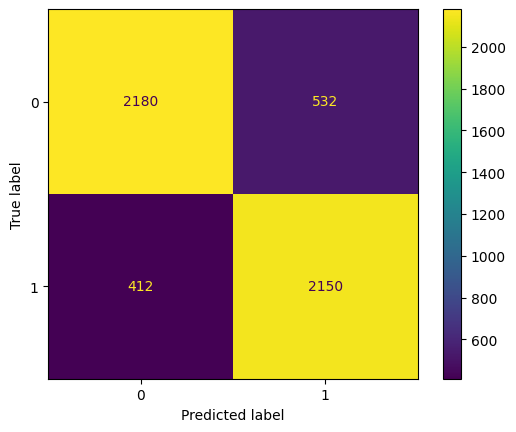

In [17]:
displayStats(cbm, "CATBOOST REV 2", X_test, y_test)

### Sanity Check

---

Let's generate a histogram of multiple CBTrees on different splits, and their respective statistics

In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
accuracies = []
for i in range(100):
    data = pd.read_csv("combined_data_nonconcat.csv",header=None)
    data = data.sample(frac=1)
    data = data.reset_index(drop=True)
    labels = data[0]
    data = data.drop(0,axis='columns')
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.30)
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()
    y_train = np.asarray(y_train.values.tolist())
    y_train = y_train.reshape(-1,1)
    y_test = np.asarray(y_test.values.tolist())
    y_test = y_test.reshape(-1,1)

    cbm = CatBoostClassifier(silent=True)
    cbm.fit(X_train,y_train)

    predictions = cbm.predict(X_test) #all of them should have this
    print("ACCURACY: "+str(accuracy_score(y_test,predictions)))
    acc = accuracy_score(y_test,predictions)
    accuracies.append(acc)

print(accuracies)

<Figure size 640x480 with 0 Axes>

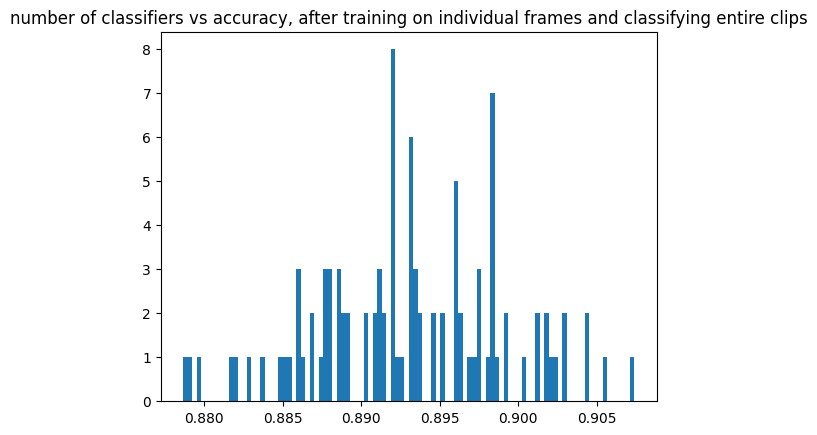

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.hist(accuracies,bins=100)
plt.title("number of classifiers vs accuracy, after training on individual frames and classifying entire clips")
plt.figure()

### Conclusions of Frame by Frame classifier

---
The frame by frame classifier seems to do really well on random frames. We can now try to extend this concept to classifying on each clip. 

---


## Clip by Clip Classifier

---

1. Import the concatenated vector data so that we have an entire clip as a row

In [58]:
data_C = pd.read_csv("data_concat.csv",header=None)
data_C = data_C.sample(frac=1)
data_C = data_C.reset_index(drop=True)
labels_C = data_C[0]
data_C = data_C.drop(0,axis='columns')
X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(data_C, labels_C, test_size=0.30, random_state=42)
X_train_C = X_train_C.to_numpy()
X_test_C = X_test_C.to_numpy()
y_train_C = np.asarray(y_train_C.values.tolist())
y_train_C = y_train_C.reshape(-1,1)
y_test_C = np.asarray(y_test_C.values.tolist())
y_test_C = y_test_C.reshape(-1,1)

In [39]:
print(pd.Series(labels_C).value_counts())
print(pd.Series(y_train_C.ravel()).value_counts())
print(pd.Series(y_test_C.ravel()).value_counts())

0.0    74
1.0    73
Name: 0, dtype: int64
0.0    52
1.0    50
dtype: int64
1.0    23
0.0    22
dtype: int64


In [40]:
print("NONCONCAT DATA SHAPES")
# print(data.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

print("CONCAT DATA SHAPES")
# print(data_C.shape)
print(X_train_C.shape)
print(X_test_C.shape)
print(y_train_C.shape)
print(y_test_C.shape)

NONCONCAT DATA SHAPES
(12306, 34)
(5274, 34)
(12306, 1)
(5274, 1)
CONCAT DATA SHAPES
(102, 2040)
(45, 2040)
(102, 1)
(45, 1)


2. Reshape to extract frame-by-frame 

In [59]:
newdimx_train = (X_train_C.shape[0] * X_train_C.shape[1])/34
X_train_Cr = np.reshape(X_train_C,(int(newdimx_train),34))

newdimx_test = (X_test_C.shape[0]*X_test_C.shape[1])/34
X_test_Cr = np.reshape(X_test_C,(int(newdimx_test),34))

print("CONCAT DATA SHAPES AFTER RESHAPING")
print(X_train_Cr.shape)
print(X_test_Cr.shape)


CONCAT DATA SHAPES AFTER RESHAPING
(6120, 34)
(2700, 34)


3. Stretch the y-labels of training and test set to fit the reshaped arrays

In [60]:
print("LABEL SHAPES BEFORE STRETCHING")
print(y_train_C.shape)
print(y_test_C.shape)

y_train_Cr = np.copy(y_train_C)
y_test_Cr = np.copy(y_test_C)

y_train_Cr = np.repeat(y_train_Cr,(X_train_Cr.shape[0])/(y_train_Cr.shape[0]))
y_train_Cr = np.reshape(y_train_Cr,(-1,1))
y_test_Cr = np.repeat(y_test_Cr,(X_test_Cr.shape[0])/(y_test_Cr.shape[0]))
y_test_Cr = np.reshape(y_test_Cr,(-1,1))

print("LABEL SHAPES AFTER STRETCHING")
print(y_train_Cr.shape)
print(y_test_Cr.shape)

LABEL SHAPES BEFORE STRETCHING
(102, 1)
(45, 1)
LABEL SHAPES AFTER STRETCHING
(6120, 1)
(2700, 1)


In [66]:
from catboost import CatBoostClassifier
cbm = CatBoostClassifier()
cbm.fit(X_train_Cr,y_train_Cr)

Learning rate set to 0.022329
0:	learn: 0.6870672	total: 5.04ms	remaining: 5.04s
1:	learn: 0.6823643	total: 9.61ms	remaining: 4.79s
2:	learn: 0.6770491	total: 14.3ms	remaining: 4.74s
3:	learn: 0.6729230	total: 19.2ms	remaining: 4.77s
4:	learn: 0.6676112	total: 23.1ms	remaining: 4.59s
5:	learn: 0.6616532	total: 26.7ms	remaining: 4.43s
6:	learn: 0.6574581	total: 33.4ms	remaining: 4.74s
7:	learn: 0.6530530	total: 38.4ms	remaining: 4.76s
8:	learn: 0.6483659	total: 42.4ms	remaining: 4.67s
9:	learn: 0.6449943	total: 49ms	remaining: 4.85s
10:	learn: 0.6412132	total: 53.4ms	remaining: 4.8s
11:	learn: 0.6377015	total: 57.6ms	remaining: 4.74s
12:	learn: 0.6341807	total: 61.5ms	remaining: 4.67s
13:	learn: 0.6305165	total: 66.2ms	remaining: 4.66s
14:	learn: 0.6271960	total: 71.7ms	remaining: 4.71s
15:	learn: 0.6249358	total: 75.6ms	remaining: 4.65s
16:	learn: 0.6218851	total: 79.4ms	remaining: 4.59s
17:	learn: 0.6189259	total: 83.6ms	remaining: 4.56s
18:	learn: 0.6158723	total: 87.8ms	remaining: 4

4) Check the frame by frame accuracy of the fit classifier

CATBOOST REV 2 STATS:
ACCURACY: 0.6481481481481481
ROC AUC: 0.6806679894179894


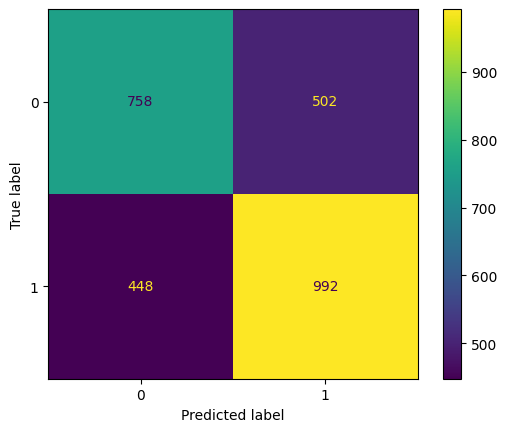

In [67]:
displayStats(cbm, "CATBOOST REV 2", X_test_Cr, y_test_Cr)

The frame by frame accuracy is worse, due to the less shuffled nature of the training dataset (we're shuffling in 60-frame chunks, instead of single frame shuffling)

Let's attempt to use this classifier to vote on clips, but if this does not work well, we may need to explore alternative strategies.

5) Classify 60 frames at a time (one clip) and take a majority consensus to classify a clip.

In [68]:
preds = []
softpreds = []
for clip in X_test_C: # go over all of the clips concat vectors in X_test_C
    clip = np.reshape(clip,(1,-1))
    numrows = int((clip.shape[0]*clip.shape[1])/34) #should be 60 for our standard, but this keeps it dynamic
    numcols = int((clip.shape[0]*clip.shape[1])/numrows) #should always end up as 34
    clip = np.reshape(clip,(numrows, numcols))
    
    #classify each row in clip
    clipPreds = cbm.predict(clip)
    clipSoftPreds = cbm.predict_proba(clip)[:,1]
    softprediction = np.average(clipSoftPreds)
    
    prediction = np.sum(clipPreds)
    if(prediction < (clipPreds.shape[0]/2)):
        prediction = 0
    else:
        prediction = 1
    
    preds.append(prediction)
    softpreds.append(softprediction)
preds = np.asarray(preds)
softpreds = np.asarray(softpreds)

ACCURACY: 0.6888888888888889
ROC AUC: 0.7440476190476191


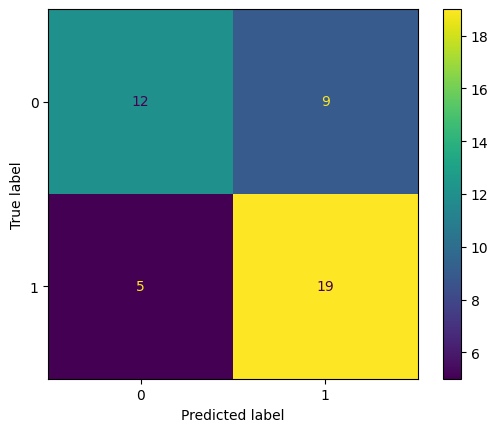

In [69]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt

preds = np.reshape(preds,(-1,1))
print("ACCURACY: "+str(accuracy_score(y_test_C,preds)))
print("ROC AUC: "+str(roc_auc_score(y_test_C,softpreds)))

cmat = confusion_matrix(y_test_C,preds)
disp = ConfusionMatrixDisplay(cmat)
disp.plot()
plt.show()

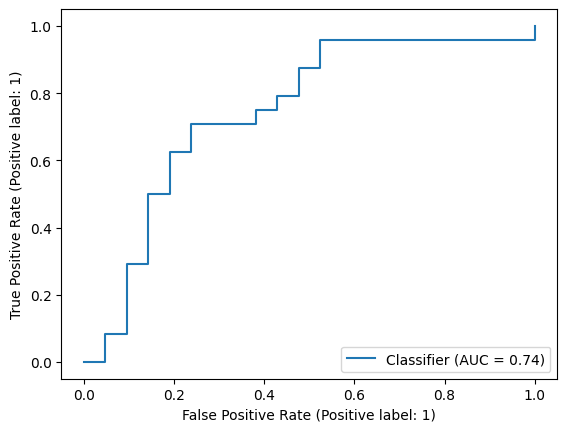

In [70]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_test_C,softpreds)

The accuracy does not drop off significantly compared to classifying individual frames in the random frame classification. One possible hyperparameter that we can tune to improve it is the bias when computing the voted score. Currently, bad frames and good frames contribute equally to the clip's prediction. However, we can adjust this to bias more towards good frames, or more towards bad frames, and see if we can boost the accuracy. 

First however, we need to generate a histogram to look at accuracy across multiple runs.

## Sanity Check
Generating histogram for clip classifier

---

In [48]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from matplotlib import pyplot as pyplot

accuracies = []
roc_aucs = []

for i in range(100):
    #get the data
    data_C = pd.read_csv("data_concat.csv",header=None)
    data_C = data_C.sample(frac=1)
    data_C = data_C.reset_index(drop=True)
    labels_C = data_C[0]
    data_C = data_C.drop(0,axis='columns')
    X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(data_C, labels_C, test_size=0.30, random_state=42)
    X_train_C = X_train_C.to_numpy()
    X_test_C = X_test_C.to_numpy()
    y_train_C = np.asarray(y_train_C.values.tolist())
    y_train_C = y_train_C.reshape(-1,1)
    y_test_C = np.asarray(y_test_C.values.tolist())
    y_test_C = y_test_C.reshape(-1,1)

    #transform
    newdimx_train = (X_train_C.shape[0] * X_train_C.shape[1])/34
    X_train_Cr = np.reshape(X_train_C,(int(newdimx_train),34))

    newdimx_test = (X_test_C.shape[0]*X_test_C.shape[1])/34
    X_test_Cr = np.reshape(X_test_C,(int(newdimx_test),34))

    y_train_Cr = np.copy(y_train_C)
    y_test_Cr = np.copy(y_test_C)

    y_train_Cr = np.repeat(y_train_Cr,(X_train_Cr.shape[0])/(y_train_Cr.shape[0]))
    y_train_Cr = np.reshape(y_train_Cr,(-1,1))
    y_test_Cr = np.repeat(y_test_Cr,(X_test_Cr.shape[0])/(y_test_Cr.shape[0]))
    y_test_Cr = np.reshape(y_test_Cr,(-1,1))

    # fit classifier
    _cbm = CatBoostClassifier(silent=True)
    _cbm.fit(X_train_Cr,y_train_Cr)
    preds = []
    softpreds = []
    for clip in X_test_C: # go over all of the clips concat vectors in X_test_C
        clip = np.reshape(clip,(1,-1))
        numrows = int((clip.shape[0]*clip.shape[1])/34) #should be 60 for our standard, but this keeps it dynamic
        numcols = int((clip.shape[0]*clip.shape[1])/numrows) #should always end up as 34
        clip = np.reshape(clip,(numrows, numcols))
        
        #classify each row in clip
        clipPreds = _cbm.predict(clip)
        clipSoftPreds = cbm.predict_proba(clip)[:,1]
        softprediction = np.average(clipSoftPreds)
        
        prediction = np.sum(clipPreds)
        if(prediction < (clipPreds.shape[0]/2)):
            prediction = 0
        else:
            prediction = 1
        
        preds.append(prediction)
        softpreds.append(softprediction)
    preds = np.asarray(preds)
    softpreds = np.asarray(softpreds)
    preds = np.reshape(preds,(-1,1))
    
    accuracies.append(accuracy_score(y_test_C,preds))
    roc_aucs.append(roc_auc_score(y_test_C,softpreds))

<Figure size 640x480 with 0 Axes>

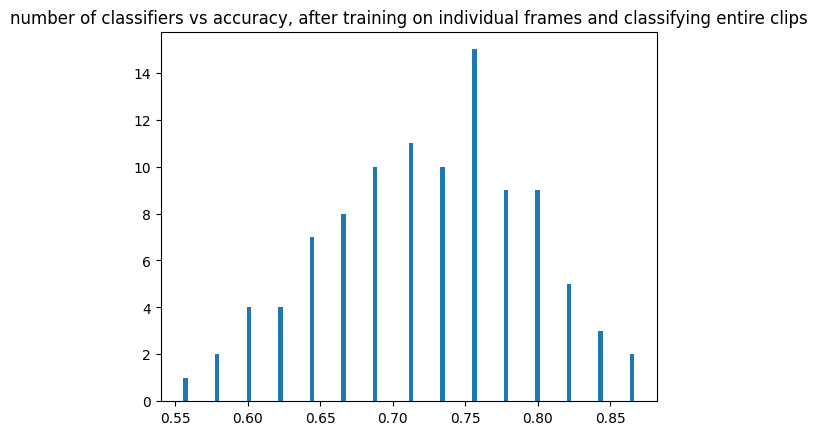

<Figure size 640x480 with 0 Axes>

In [49]:
plt.hist(accuracies,bins=100)
plt.title("number of classifiers vs accuracy, after training on individual frames and classifying entire clips")
plt.figure()

<Figure size 640x480 with 0 Axes>

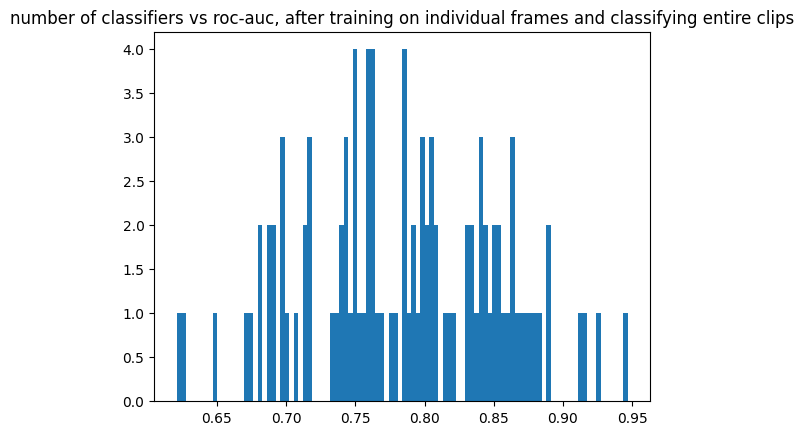

<Figure size 640x480 with 0 Axes>

In [55]:
plt.hist(roc_aucs,bins=100)
plt.title("number of classifiers vs roc-auc, after training on individual frames and classifying entire clips")
plt.figure()

In [50]:
accuracies = np.asarray(accuracies)
print("STD Deviation of accuracy: "+str(np.std(accuracies)))
print("mean of accuracy: "+str(np.mean(accuracies)))

STD Deviation of accuracy: 0.06965027274768679
mean of accuracy: 0.7240000000000001


In [57]:
roc_aucs = np.asarray(roc_aucs)
print("STD Deviation of ROC-AUC: "+str(np.std(roc_aucs)))
print("mean of ROC-AUC: "+str(np.mean(roc_aucs)))

STD Deviation of ROC-AUC: 0.0691003828080278
mean of ROC-AUC: 0.7851887420121393


## Bias parameter tuning

Tuning the proportion of good/bad frames to classify a clip

---

Mean accuracy: 0.6791111111111111
Mean ROC-AUC: 0.7946245837210465
STD Deviation of accuracy: 0.07175541447286635
STD Deviation of ROC-AUC: 0.06740518323844431

Mean accuracy: 0.7262222222222224
Mean ROC-AUC: 0.7941267602804696
STD Deviation of accuracy: 0.06797821001642392
STD Deviation of ROC-AUC: 0.06345167268278358

Mean accuracy: 0.6875555555555556
Mean ROC-AUC: 0.7934255539002792
STD Deviation of accuracy: 0.062128500845296045
STD Deviation of ROC-AUC: 0.05788758590302679



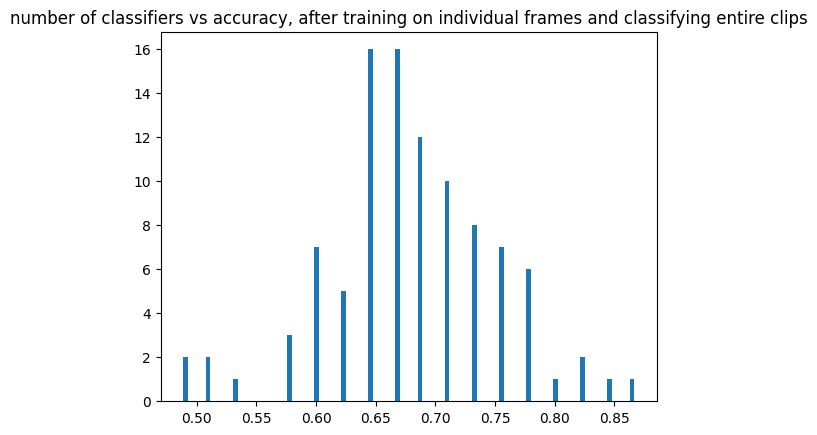

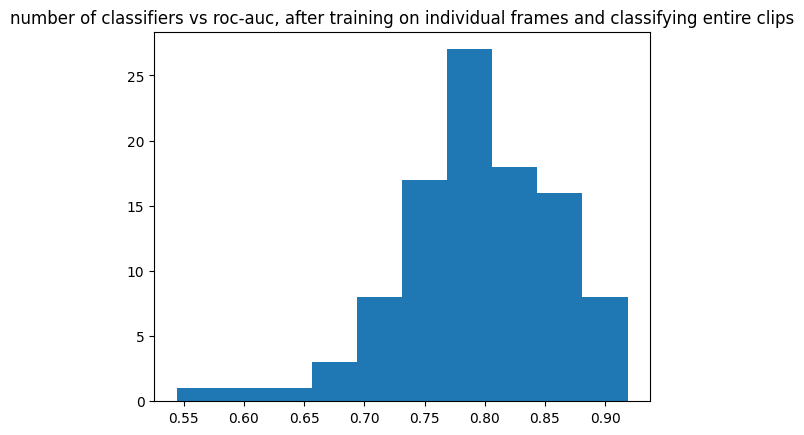

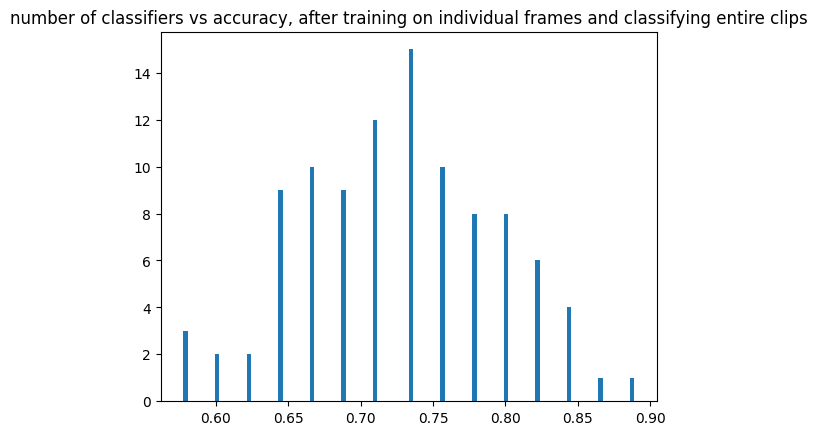

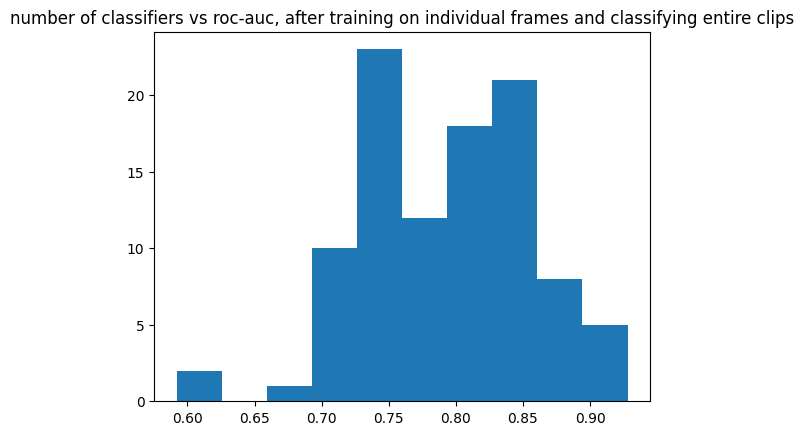

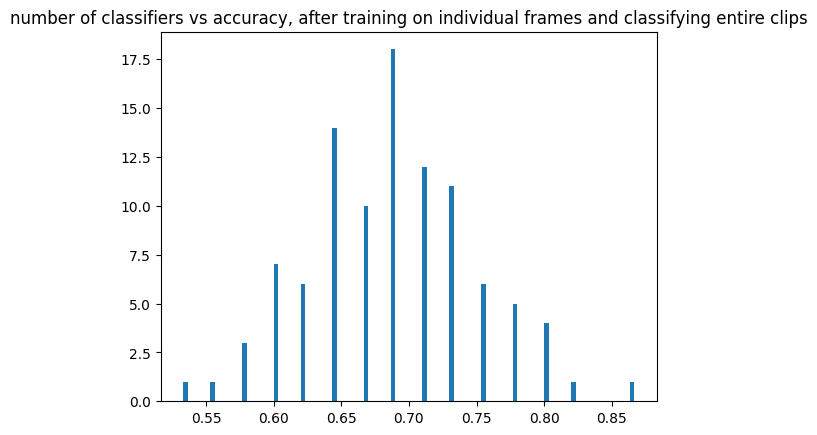

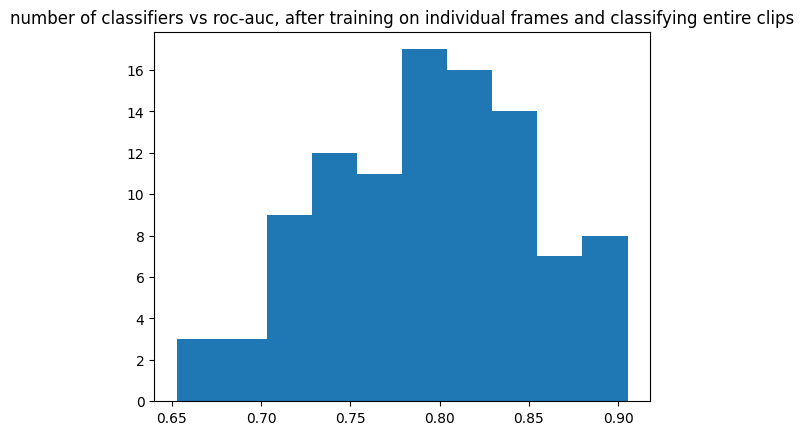

<Figure size 640x480 with 0 Axes>

In [78]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from matplotlib import pyplot as pyplot
from progressbar import ProgressBar
pbar = ProgressBar()


for bias in [1/4,1/2,3/4]:
    accuracies = []
    roc_aucs = []
    for i in range(100):
        #get the data
        data_C = pd.read_csv("data_concat.csv",header=None)
        data_C = data_C.sample(frac=1)
        data_C = data_C.reset_index(drop=True)
        labels_C = data_C[0]
        data_C = data_C.drop(0,axis='columns')
        X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(data_C, labels_C, test_size=0.30, random_state=42)
        X_train_C = X_train_C.to_numpy()
        X_test_C = X_test_C.to_numpy()
        y_train_C = np.asarray(y_train_C.values.tolist())
        y_train_C = y_train_C.reshape(-1,1)
        y_test_C = np.asarray(y_test_C.values.tolist())
        y_test_C = y_test_C.reshape(-1,1)

        #transform
        newdimx_train = (X_train_C.shape[0] * X_train_C.shape[1])/34
        X_train_Cr = np.reshape(X_train_C,(int(newdimx_train),34))

        newdimx_test = (X_test_C.shape[0]*X_test_C.shape[1])/34
        X_test_Cr = np.reshape(X_test_C,(int(newdimx_test),34))

        y_train_Cr = np.copy(y_train_C)
        y_test_Cr = np.copy(y_test_C)

        y_train_Cr = np.repeat(y_train_Cr,(X_train_Cr.shape[0])/(y_train_Cr.shape[0]))
        y_train_Cr = np.reshape(y_train_Cr,(-1,1))
        y_test_Cr = np.repeat(y_test_Cr,(X_test_Cr.shape[0])/(y_test_Cr.shape[0]))
        y_test_Cr = np.reshape(y_test_Cr,(-1,1))

        # fit classifier
        _cbm = CatBoostClassifier(silent=True)
        _cbm.fit(X_train_Cr,y_train_Cr)
        preds = []
        softpreds = []
        for clip in X_test_C: # go over all of the clips concat vectors in X_test_C
            clip = np.reshape(clip,(1,-1))
            numrows = int((clip.shape[0]*clip.shape[1])/34) #should be 60 for our standard, but this keeps it dynamic
            numcols = int((clip.shape[0]*clip.shape[1])/numrows) #should always end up as 34
            clip = np.reshape(clip,(numrows, numcols))
            
            #classify each row in clip
            clipPreds = _cbm.predict(clip)
            clipSoftPreds = _cbm.predict_proba(clip)[:,1]
            softprediction = np.average(clipSoftPreds)
            
            prediction = np.sum(clipPreds)
            if(prediction < int(clipPreds.shape[0]*bias)): 
                prediction = 0
            else:
                prediction = 1
            
            preds.append(prediction)
            softpreds.append(softprediction)
        preds = np.asarray(preds)
        softpreds = np.asarray(softpreds)
        preds = np.reshape(preds,(-1,1))
        
        accuracies.append(accuracy_score(y_test_C,preds))
        roc_aucs.append(roc_auc_score(y_test_C,softpreds))
    
    plt.hist(accuracies,bins=100)
    plt.title("number of classifiers vs accuracy, after training on individual frames and classifying entire clips")
    plt.figure()
    plt.hist(roc_aucs,bins=10)
    plt.title("number of classifiers vs roc-auc, after training on individual frames and classifying entire clips")
    plt.figure()
    accuracies = np.asarray(accuracies)
    roc_aucs = np.asarray(roc_aucs)
    print("Mean accuracy: "+str(np.mean(accuracies)))
    print("Mean ROC-AUC: "+str(np.mean(roc_aucs)))
    print("STD Deviation of accuracy: "+str(np.std(accuracies)))
    print("STD Deviation of ROC-AUC: "+str(np.std(roc_aucs))+"\n")


The bias parameter that has the best accuracy also does not differ greatly from the others in ROC-AUC. As such, I believe that having 1/2 as the bias parameter (good and bad frames equally weighted) is the best, so that we get a good result on both metrics. If ROC-AUC is the only metric that we want to consider, then a bias of 3/4ths performs better.

### Conclusion of Clip Classifier using frame classification

---

We can see that the accuracy has improved over the raw clip classification, and that the standard deviation of that accuracy itself has gone down. This makes sense, as the classifier has much more data to train on, and can better. By classifying the frames of each clip and taking a majority vote of good frames vs bad frames, it also softens the impact of minor deviations, whereas if classifying the entire clip all at once, it is possible that a deviation at a certain point in the shot affects the classification very strongly. This approach classes deviations equally, and doesn't let one bad frame outweigh multiple good frames.

The downside of this approach is that it completely disregards the temporal relationship between the frames themselves. If there is a good shot, and it's frames were scrambled, it would not actually be visually representative of a good basketball free throw. However, this classifier will still likely identify it as a good shot. 

Our other attempts of using different types of classifiers all performed worse than this one. We also tried to design a model where we had independent classifiers for each quarter of a clip, with a similar voting scheme to the model above, but this one did not perform much better, and was not worth the added complexity.

In [ ]:
import pickle
with open('r2cboost.pk1','wb') as file:
    pickle.dump(cbm,file)